In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install libportaudio2
!pip install sounddevice

In [3]:
import numpy as np
import pylab as plt
import scipy.signal as sg
import pandas as pd
import sounddevice as sd
from scipy.io.wavfile import read as read_wav

from IPython.display import Audio, display
def play(x, fs):
    display(Audio(x, rate=fs))

plt.rcParams["figure.figsize"] = (8,2)
plt.rcParams["figure.dpi"] = 150

In [4]:
import os
def load_sample(label, sample_number, play_sample=False):
    data_dir = '/content/drive/MyDrive/НИС АДИС 2022/data_lecture_7'
    samples_dir = os.path.join(data_dir, label)
    sample_name = os.listdir(samples_dir)[sample_number]
    sample_path = os.path.join(samples_dir, sample_name)
    fs, x = read_wav(sample_path)
    x = (x-x.mean())/x.std()
    x_zero_padded = np.zeros(fs)
    x_zero_padded[:min(fs, len(x))] = x[:fs]
    if play_sample: play(x_zero_padded, fs)
    return x_zero_padded, fs


x, fs = load_sample('dog', 45 , play_sample=True)
t = np.arange(len(x))/fs
print('fs = {}Hz\nx[n] = {}'.format(fs, x)) 

fs = 16000Hz
x[n] = [0.22642108 0.35547852 0.26994045 ... 0.         0.         0.        ]


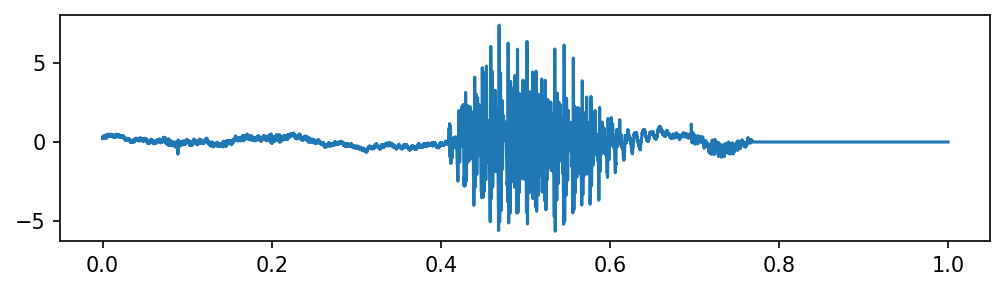

In [7]:
plt.plot(t, x)

(0.4, 0.5)

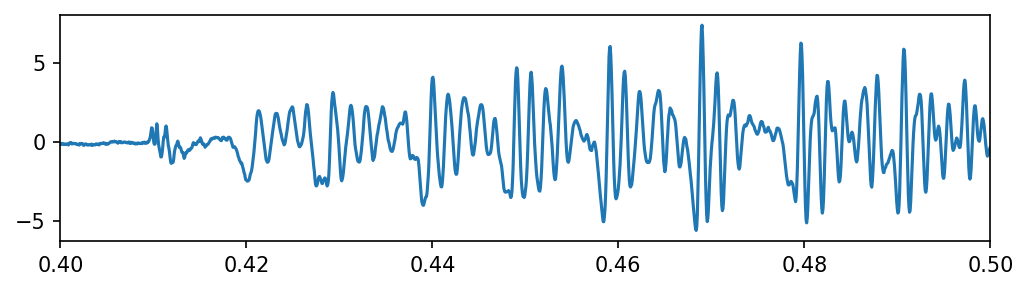

In [9]:
plt.plot(t, x)
plt.xlim(0.4, 0.5)

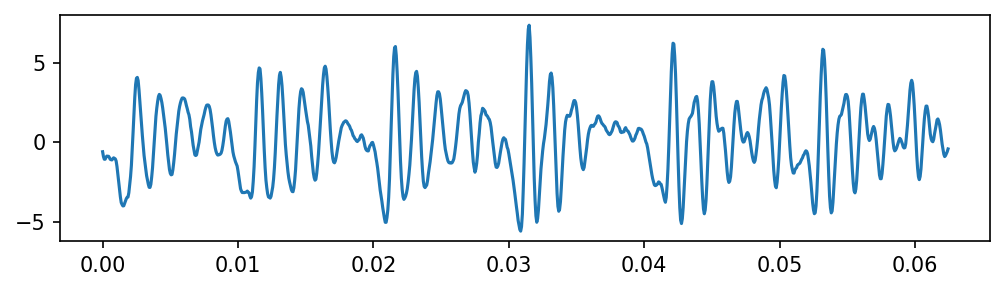

In [12]:
nperseg = 1000
start = 7000
x_seg = x[start:start + nperseg]
plt.plot(np.arange(nperseg)/fs, x_seg)

Text(0.5, 0, 'f, Hz')

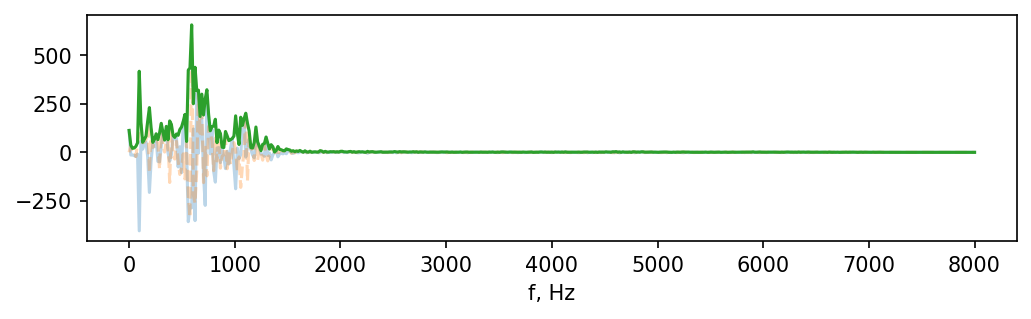

In [14]:
start = 7000
x_seg = x[start:start + nperseg]
seg_ind = np.arange(start, start + nperseg)

xf = np.fft.rfft(x_seg)
freq = np.fft.rfftfreq(nperseg, d=1/fs) 

plt.plot(freq, xf.real, alpha=0.3), 
plt.plot(freq, xf.imag, '--', alpha=0.3)
plt.plot(freq, np.abs(xf))
plt.xlabel('f, Hz')

# 2. Short-time Fourier transform (STFT)

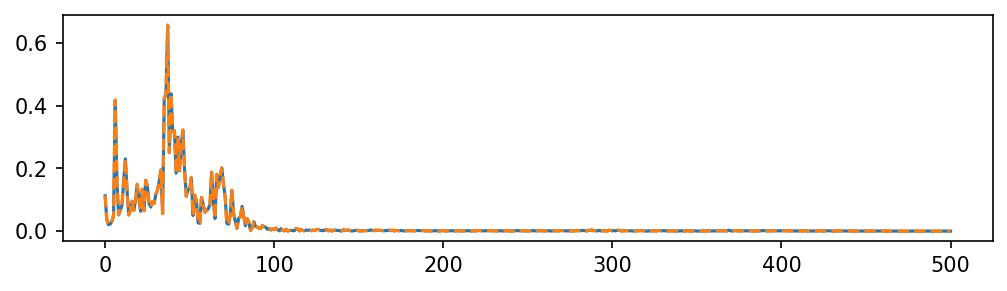

In [15]:
f, t, xft = sg.stft(x, fs, nperseg=nperseg, window=np.ones(nperseg), padded=False, boundary=None, noverlap=int(nperseg*0.9))
plt.plot(np.abs(xft[:, start//100]))
plt.plot(np.abs(xf/nperseg), '--')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Time [sec]')

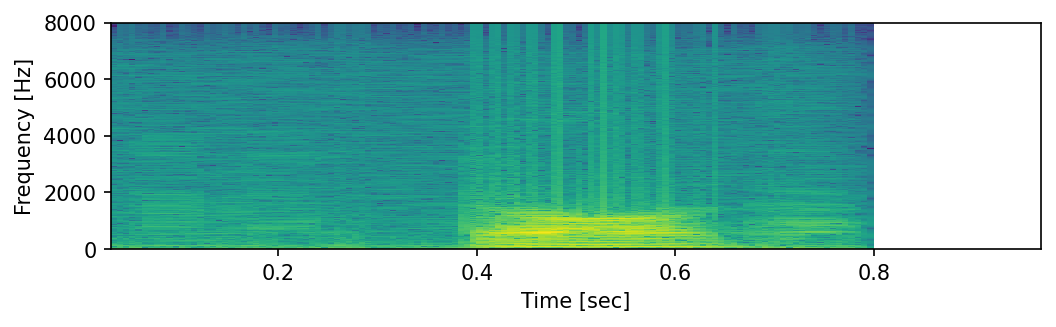

In [16]:
plt.pcolormesh(t, f, np.log(np.abs(xft)))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# plt.ylim(0, 3000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(501, 151)


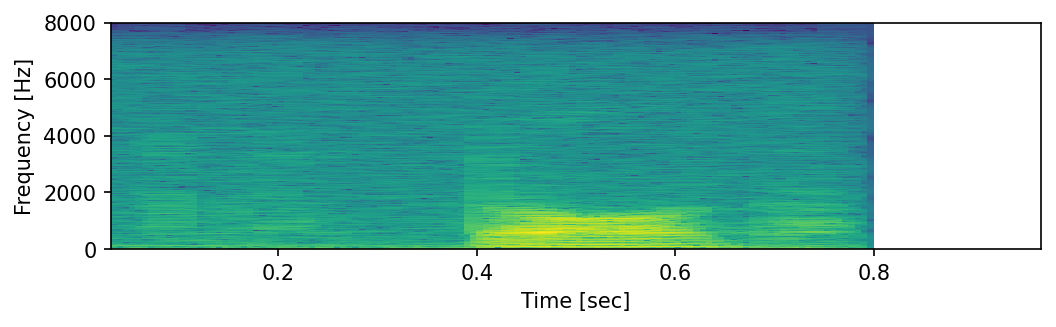

In [17]:
nperseg=1000
f, t, xft = sg.spectrogram(x, fs, scaling='spectrum', nperseg=nperseg, noverlap=int(nperseg*0.9))
plt.pcolormesh(t, f, np.log(xft))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

print(xft.shape)

Text(0.5, 0, 'Freq [Hz]')

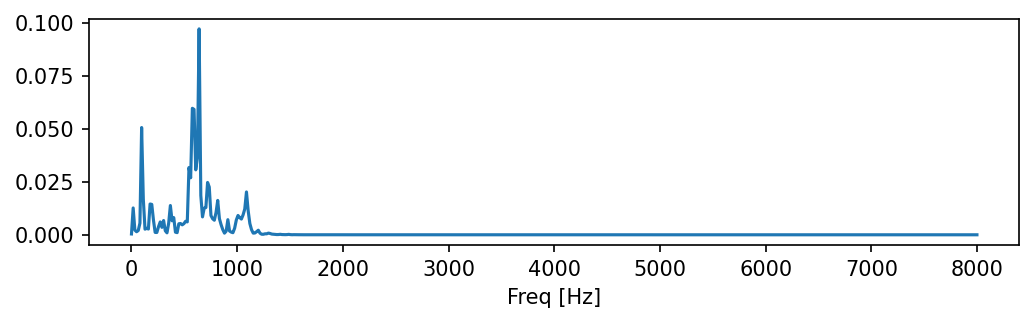

In [18]:
alpha_pow = xft.mean(1)
plt.plot(f, alpha_pow)
plt.xlabel('Freq [Hz]')

Text(0.5, 0, 'Freq, Hz')

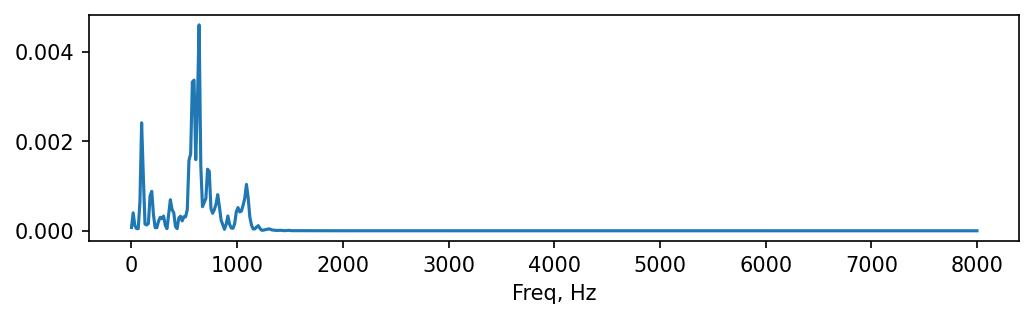

In [19]:
freq, pxx = sg.welch(x, fs, nperseg=nperseg, noverlap=int(nperseg*0.9))
plt.plot(freq, pxx)
plt.xlabel('Freq, Hz') 

Text(0.5, 0, 'Freq., Hz')

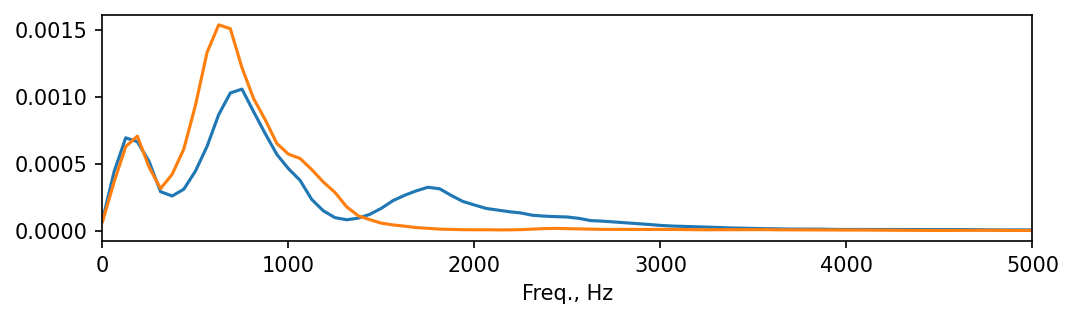

In [21]:
labels = ['cat', 'dog']
mean_spectra = []
for label in labels:
    spectra = []
    for k in range(250):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        spectra.append(spectrum)
    mean_spectrum = np.mean(spectra, 0)
    std_spectrum = np.std(spectra, 0)
    plt.plot(freq, mean_spectrum)
#     plt.fill_between(freq, mean_spectrum-std_spectrum, mean_spectrum+std_spectrum, alpha=0.5)
    mean_spectra.append(mean_spectrum)
mean_spectra = np.array(mean_spectra)
plt.xlim(0, 5000)
plt.xlabel('Freq., Hz')

array([1737.5, 2137.5])

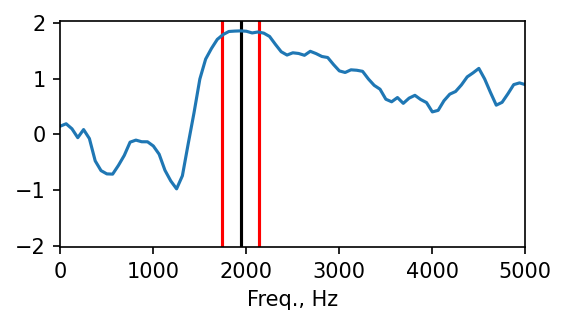

In [22]:
fig, axes = plt.subplots(1, figsize=(4,2), dpi=150, sharex=True, sharey=True)
spectra_diff = 2*(mean_spectra[0]-mean_spectra[1])/(mean_spectra[0]+mean_spectra[1])
main_freq = freq[np.argmax(np.abs(spectra_diff))]
sign = np.sign(spectra_diff[np.argmax(np.abs(spectra_diff))])
band = np.array([-1, 1])*200 + main_freq
plt.axvline(main_freq, color='k')
[plt.axvline(f, color='r') for f in band]
plt.plot(freq, spectra_diff)
plt.xlim(0, 5000)
plt.xlabel('Freq., Hz')
band

In [23]:
freq_slice = (freq>band[0]) & (freq<band[1])
threshold = np.exp(np.log(mean_spectra[:, freq_slice]).mean())
print(threshold)

4.63694921470913e-05


In [25]:
from time import sleep
print('{:12s} {:12s} {:12s}'.format('prediction', 'actual', 'error'))
for label in labels:
    for k in range(0, 5):
        x, fs = load_sample(label, k)
        freq, spectrum = sg.welch(x, fs)
        label_n = (spectrum[freq_slice].mean() < threshold)
        if sign < 0: label_n = ~label_n
        prediction = labels[int(label_n)]
        print('{:12s} {:12s} {}'.format(prediction, label, '' if prediction==label else 'x'))
        play(x, fs), sleep(1.5)

prediction   actual       error       
cat          cat          


dog          cat          x


cat          cat          


cat          cat          


cat          cat          


dog          dog          


dog          dog          


dog          dog          


dog          dog          


dog          dog          
